# Classifying Digits 0 to 4 of MNIST 

The goal of this project is to build and train a deep feed forward neural network to classify the 
first five digits, 0 to 4, of the MNIST dataset. 

Procedure:
* Download and preprocess MNIST dataset
* Build DNN and train on dataset
* Evaluate test accuracy of model and make some predictions
* Tweak model to see if we achieve better results

#### Import libraries we are going to use

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
%matplotlib inline

#### Download and preprocess MNIST dataset

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


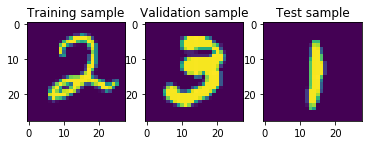

In [2]:
#load dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

valid_size = 5000

#extract digits 0 to 4 of training dataset
train_index_0_4 = np.nonzero(mnist.train.labels <= 4)[0]
mnist_train_images_0_4 = mnist.train.images[train_index_0_4]
mnist_train_labels_0_4 = mnist.train.labels[train_index_0_4]

#extract digits 0 to 4 of validation dataset
valid_index_0_4 = np.nonzero(mnist.validation.labels <= 4)[0]
mnist_valid_images_0_4 = mnist.validation.images[valid_index_0_4]
mnist_valid_labels_0_4 = mnist.validation.labels[valid_index_0_4]

#extract digits 0 to 4 of test dataset
test_index_0_4 = np.nonzero(mnist.test.labels <= 4)[0]
mnist_test_images_0_4 = mnist.test.images[test_index_0_4]
mnist_test_labels_0_4 = mnist.test.labels[test_index_0_4]

#display a sample of training, validation and test images
plt.subplot(131)
plt.imshow(mnist_train_images_0_4[10].reshape(28,28))
plt.title('Training sample')
plt.subplot(132)
plt.imshow(mnist_valid_images_0_4[999].reshape(28,28))
plt.title('Validation sample')
plt.subplot(133)
plt.imshow(mnist_test_images_0_4[1060].reshape(28,28))
plt.title('Test sample')
plt.show()

#### Build and train DNN
DNN to train consists of 5 hidden layers of 100 units each and an output layer of 5 units, one for each digit. Model is built and trained using low-level Tensorflow API

In [3]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    hidden2 = my_hidden_layer(hidden1,name='hidden2')
    hidden3 = my_hidden_layer(hidden2,name='hidden3')
    hidden4 = my_hidden_layer(hidden3,name='hidden4')
    hidden5 = my_hidden_layer(hidden4,name='hidden5')
    logits = tf.layers.dense(hidden5,n_outputs,name='logits')
    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the model
saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


In [4]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize variables
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        shuffle_idx = np.random.permutation(mnist_train_labels_0_4.shape[0])
        x_batches = np.array_split(mnist_train_images_0_4[shuffle_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_0_4[shuffle_idx],batch_size)
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={X:x_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        saver.save(sess,'./saved_models/model_0_4.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    saver.save(sess,'./saved_models/model_0_4_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.964286 Validation Accuracy: 0.982408
1000 Training Accuracy: 1.0 Validation Accuracy: 0.980453
1500 Training Accuracy: 1.0 Validation Accuracy: 0.985536
2000 Training Accuracy: 1.0 Validation Accuracy: 0.975371
2500 Training Accuracy: 1.0 Validation Accuracy: 0.985536
3000 Training Accuracy: 1.0 Validation Accuracy: 0.98749
3500 Training Accuracy: 1.0 Validation Accuracy: 0.992572
4000 Training Accuracy: 1.0 Validation Accuracy: 0.989054
4500 Training Accuracy: 1.0 Validation Accuracy: 0.989054
5000 Training Accuracy: 0.982143 Validation Accuracy: 0.9914
5500 Training Accuracy: 0.982143 Validation Accuracy: 0.989445
6000 Training Accuracy: 1.0 Validation Accuracy: 0.988663
6500 Training Accuracy: 1.0 Validation Accuracy: 0.988663
7000 Training Accuracy: 1.0 Validation Accuracy: 0.989445
7500 Training Accuracy: 1.0 Validation Accuracy: 0.99179
8000 Training Accuracy: 1.0 Validation Accuracy: 0.99179
8500 Training Accuracy: 1.0 Validation Accuracy: 0.99179


In [5]:
# Let's evaluate accuracy of model on test dataset
with tf.Session() as sess:
    #restore saved model
    saver.restore(sess,'./saved_models/model_0_4_final.ckpt')
    accu_test = accuracy.eval(feed_dict={X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
Test Accuracy: 0.993578


In [6]:
# Let's do some predictions on the test dataset using our model
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={X:mnist_test_images_0_4[1989:1995]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[1989:1995])

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_final.ckpt
Prediction: [4 0 2 3 2 4]
Target: [4 0 2 3 2 4]


Looks like our trained model is working great! Can we do better?

#### Batch Normalization
Let us tweak our model by adding batch normalization to see if training converges faster and we get a more accurate model

In [7]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')
is_training = tf.placeholder(tf.bool,shape=(),name="is_training")

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    my_batch_norm_layer = partial(tf.layers.batch_normalization,momentum=0.9,training=is_training)
    
    
    hidden1 = my_hidden_layer(X,name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1),name='bn1')
    hidden2 = my_hidden_layer(bn1,name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2),name='bn2')
    hidden3 = my_hidden_layer(bn2,name='hidden3')
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3),name='bn3')
    hidden4 = my_hidden_layer(bn3,name='hidden4')
    bn4 = tf.nn.elu(my_batch_norm_layer(hidden4),name='bn4')
    hidden5 = my_hidden_layer(bn4,name='hidden5')
    bn5 = tf.nn.elu(my_batch_norm_layer(hidden5),name='bn5')
    logits_before_bn = tf.layers.dense(bn5,n_outputs,name='logits_before_bn')
    logits = my_batch_norm_layer(logits_before_bn,name='logits')
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the model
saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  
   

In [8]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize variables
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        shuffle_idx = np.random.permutation(mnist_train_labels_0_4.shape[0])
        x_batches = np.array_split(mnist_train_images_0_4[shuffle_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_0_4[shuffle_idx],batch_size)
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={is_training:True,X:x_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={is_training:False,X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={is_training:False,X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        saver.save(sess,'./saved_models/model_0_4_with_BN.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    saver.save(sess,'./saved_models/model_0_4_with_BN_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.982143 Validation Accuracy: 0.977326
1000 Training Accuracy: 0.982143 Validation Accuracy: 0.956998
1500 Training Accuracy: 0.964286 Validation Accuracy: 0.961689
2000 Training Accuracy: 1.0 Validation Accuracy: 0.969898
2500 Training Accuracy: 0.982143 Validation Accuracy: 0.980063
3000 Training Accuracy: 0.928571 Validation Accuracy: 0.971071
3500 Training Accuracy: 0.946429 Validation Accuracy: 0.939015
4000 Training Accuracy: 0.964286 Validation Accuracy: 0.952697
4500 Training Accuracy: 0.946429 Validation Accuracy: 0.976544
5000 Training Accuracy: 0.964286 Validation Accuracy: 0.971071
5500 Training Accuracy: 1.0 Validation Accuracy: 0.981235
6000 Training Accuracy: 0.964286 Validation Accuracy: 0.97498
6500 Training Accuracy: 1.0 Validation Accuracy: 0.979281
7000 Training Accuracy: 1.0 Validation Accuracy: 0.985145
7500 Training Accuracy: 1.0 Validation Accuracy: 0.982017
8000 Training Accuracy: 0.982143 Validation Accuracy: 0.972244
8500 Training Accur

In [9]:
# Test accuracy of batch normalization model on test data
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_with_BN_final.ckpt')
    accu_test = accuracy.eval(feed_dict={is_training:False,X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_with_BN_final.ckpt
Test Accuracy: 0.981903


In [10]:
# do some predictions on the test data using batch normalization model
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_with_BN_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={is_training:False,X:mnist_test_images_0_4[1989:1995]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[1989:1995])

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_with_BN_final.ckpt
Prediction: [4 0 2 3 2 4]
Target: [4 0 2 3 2 4]


Looks like we do not gain adding batch normalization. Our original model still performs better and 
took fewer steps in training

#### Using dropout

Will using dropout help our model generalize better than originally?

In [11]:
# Build phase of model

units = 100
n_outputs = 5
n_inputs = 28 * 28 # each image of MNIST is 28 by 28 pixels
dropout_rate = 0.5

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int64,shape=(None),name='y')
is_training = tf.placeholder(tf.bool,shape=(),name="is_training")

with tf.name_scope('dnn'):
    #use He initialization for weight initialization and Elu for activation function
    he_init = tf.contrib.layers.variance_scaling_initializer()
    my_hidden_layer = partial(tf.layers.dense,kernel_initializer=he_init,activation=tf.nn.elu,units=units)
    
    
    x_drop = tf.layers.dropout(X,rate=dropout_rate,training=is_training,name='x_drop')
    hidden1 = my_hidden_layer(x_drop,name='hidden1')
    hidden1_drop = tf.layers.dropout(hidden1,rate=dropout_rate,training=is_training,name='hidden1_drop')
    hidden2 = my_hidden_layer(hidden1_drop,name='hidden2')
    hidden2_drop = tf.layers.dropout(hidden2,rate=dropout_rate,training=is_training,name='hidden2_drop')
    hidden3 = my_hidden_layer(hidden2_drop,name='hidden3')
    hidden3_drop = tf.layers.dropout(hidden3,rate=dropout_rate,training=is_training,name='hidden3_drop')
    hidden4 = my_hidden_layer(hidden3_drop,name='hidden4')
    hidden4_drop = tf.layers.dropout(hidden4,rate=dropout_rate,training=is_training,name='hidden4_drop') 
    hidden5 = my_hidden_layer(hidden4_drop,name='hidden5')
    hidden5_drop = tf.layers.dropout(hidden5,rate=dropout_rate,training=is_training,name='hidden5_drop') 
    logits = tf.layers.dense(hidden5_drop,n_outputs,name='logits')

    
    
with tf.name_scope('loss'):
    #output layer uses softmax activation function
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss = tf.reduce_mean(xentropy,name='loss')
    
    
with tf.name_scope('train'):
    #optimizer is Adam optimizer with a learning rate of 0.001 
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
    training_op = optimizer.minimize(loss,name='training_op')
    
    
with tf.name_scope('eval'):
    #operation to evaluate accuracy of model
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='eval')
    

#operation to initialize variables
init = tf.global_variables_initializer()

#used to save the model
saver = tf.train.Saver()

#path to where tensorboard log is saved
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tensorboard"
logdir = "{}/run-{}/".format(root_logdir, now)

#save graph and  stats used on the tensorboard
valid_accuracy = tf.placeholder(tf.float32,shape=())
valid_summary = tf.summary.scalar('valid_accuracy',valid_accuracy)
summary_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())  


In [12]:
# Training phase of model

# stop training if validation accuracy does not improve in 10 epochs
# using early stopping to minimize overfitting
max_epoch_without_valid_improve = 10 

batch_size = 500
global_step_count = 0 
epoch_count = 0
best_accu_valid = 0


with tf.Session() as sess:
    init.run() #initialize variables
    
    while epoch_count < max_epoch_without_valid_improve:
        #generate random mini-batches to use for training in current epoch
        shuffle_idx = np.random.permutation(mnist_train_labels_0_4.shape[0])
        x_batches = np.array_split(mnist_train_images_0_4[shuffle_idx],batch_size)
        y_batches = np.array_split(mnist_train_labels_0_4[shuffle_idx],batch_size)
        for x_batch,y_batch in zip(x_batches,y_batches):
            sess.run(training_op,feed_dict={is_training:True,X:x_batch,y:y_batch})
            global_step_count += 1
        #evaluate training and validation accuracy
        accu_train = accuracy.eval(feed_dict={is_training:False,X:x_batch,y:y_batch})
        accu_valid = accuracy.eval(feed_dict={is_training:False,X:mnist_valid_images_0_4,y:mnist_valid_labels_0_4})  
        if accu_valid > best_accu_valid:
            best_accu_valid = accu_valid
            epoch_count = 0
        else:
            epoch_count += 1
        #save current validation and step count to tensorboard
        summary_str = valid_summary.eval(feed_dict={valid_accuracy:accu_valid})
        summary_writer.add_summary(summary_str, global_step_count)
        #save model generated so far
        saver.save(sess,'./saved_models/model_0_4_with_dropout.ckpt')
        print(global_step_count,'Training Accuracy:',accu_train,'Validation Accuracy:',accu_valid)
    
    # save final model at end of trainiing
    saver.save(sess,'./saved_models/model_0_4_with_dropout_final.ckpt')
        

summary_writer.flush()
summary_writer.close()

500 Training Accuracy: 0.946429 Validation Accuracy: 0.945661
1000 Training Accuracy: 0.982143 Validation Accuracy: 0.959734
1500 Training Accuracy: 0.946429 Validation Accuracy: 0.963643
2000 Training Accuracy: 0.946429 Validation Accuracy: 0.96638
2500 Training Accuracy: 0.982143 Validation Accuracy: 0.967553
3000 Training Accuracy: 0.982143 Validation Accuracy: 0.969507
3500 Training Accuracy: 0.910714 Validation Accuracy: 0.972635
4000 Training Accuracy: 1.0 Validation Accuracy: 0.971462
4500 Training Accuracy: 0.982143 Validation Accuracy: 0.973417
5000 Training Accuracy: 0.982143 Validation Accuracy: 0.976935
5500 Training Accuracy: 0.982143 Validation Accuracy: 0.975371
6000 Training Accuracy: 0.964286 Validation Accuracy: 0.978499
6500 Training Accuracy: 0.964286 Validation Accuracy: 0.977717
7000 Training Accuracy: 0.964286 Validation Accuracy: 0.981626
7500 Training Accuracy: 0.946429 Validation Accuracy: 0.979281
8000 Training Accuracy: 0.982143 Validation Accuracy: 0.981235

In [13]:
# Test accuracy of dropout model on test data
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_with_dropout_final.ckpt')
    accu_test = accuracy.eval(feed_dict={is_training:False,X:mnist_test_images_0_4,y:mnist_test_labels_0_4})  
    print('Test Accuracy:',accu_test)

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_with_dropout_final.ckpt
Test Accuracy: 0.99066


In [14]:
# do some predictions on the test data using dropout model
with tf.Session() as sess:
    saver.restore(sess,'./saved_models/model_0_4_with_dropout_final.ckpt')
    label_pred = np.argmax(sess.run(logits,feed_dict={is_training:False,X:mnist_test_images_0_4[1989:1995]}),axis=1) 
    
print('Prediction:',label_pred)
print('Target:',mnist_test_labels_0_4[1989:1995])

INFO:tensorflow:Restoring parameters from ./saved_models/model_0_4_with_dropout_final.ckpt
Prediction: [4 0 2 3 2 4]
Target: [4 0 2 3 2 4]


whoops! Looks like the dropout model does not outperform our original model either

#### Conclusion

We have successfully trained a deep feed forward neural network to classify digits 0 to 4 of MNIST dataset with less than 1% error. It is still possible to achieve better accuracy with other neural network architectures like **CNN**, but that is beyond the scope of this project.